### Stock Market Prediction And Forecasting Using Stacked LSTM

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import os
import ta
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit


### Data Loading & Preprocessing

In [3]:
# Load the dataset
file_path = 'nasdaq.csv'
nasdaq_data = pd.read_csv(file_path)

In [4]:
nasdaq_data.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,EMA_50,EMA_200,RSI,MACD,MACD_Signal,MACD_Hist
0,4776,1990-01-02 05:00:00+00:00,452.899994,459.299988,452.700012,459.299988,110720000,453.490768,444.839773,62.885333,-1.049759,-2.890670,1.840911
1,4777,1990-01-03 05:00:00+00:00,461.100006,461.600006,460.000000,460.899994,152660000,453.781326,444.999576,64.551665,-0.049565,-2.322449,2.272884
2,4778,1990-01-04 05:00:00+00:00,460.399994,460.799988,456.899994,459.399994,147950000,454.001666,445.142864,61.752523,0.614970,-1.734965,2.349935
3,4779,1990-01-05 05:00:00+00:00,457.899994,459.399994,457.799988,458.200012,137230000,454.166307,445.272785,59.528642,1.032884,-1.181395,2.214279
4,4780,1990-01-08 05:00:00+00:00,457.100006,458.700012,456.500000,458.700012,115500000,454.344100,445.406390,60.172252,1.388424,-0.667432,2.055856


In [5]:
nasdaq_data.tail()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,EMA_50,EMA_200,RSI,MACD,MACD_Signal,MACD_Hist
8693,13469,2024-07-08 04:00:00+00:00,18371.859375,18416.939453,18342.599609,18403.740234,5286260000,17189.750516,15675.307967,76.595822,346.377771,314.919227,31.458543
8694,13470,2024-07-09 04:00:00+00:00,18465.019531,18511.890625,18381.599609,18429.289062,4839140000,17238.359870,15702.710764,76.984401,357.604954,323.456373,34.148581
8695,13471,2024-07-10 04:00:00+00:00,18512.089844,18655.189453,18467.580078,18647.449219,5228240000,17293.618276,15732.011644,80.032922,379.729000,334.710898,45.018102
8696,13472,2024-07-11 04:00:00+00:00,18659.250000,18671.070312,18238.779297,18283.410156,6366620000,17332.433644,15757.398694,64.645599,363.695104,340.507739,23.187365
8697,13473,2024-07-12 04:00:00+00:00,18303.640625,18556.730469,18293.599609,18398.449219,5845930000,17374.238176,15783.677803,66.816775,356.165167,343.639225,12.525943


In [6]:
# Add moving averages
nasdaq_data['MA10'] = nasdaq_data['Close'].rolling(window=10).mean()
nasdaq_data['MA50'] = nasdaq_data['Close'].rolling(window=10).mean()
nasdaq_data['MA200'] = nasdaq_data['Close'].rolling(window=10).mean()

In [8]:
nasdaq_data.dropna(inplace=True)  # Drop rows with NaN values

In [9]:
# Drop the unnecessary columns
df = nasdaq_data.drop(columns=['Unnamed: 0', 'Date', 'Volume', 'Open', 'High',	'Low'	])


In [10]:
df.head(15)

,Close,EMA_50,EMA_200,RSI,MACD,MACD_Signal,MACD_Hist,MA10,MA50,MA200
9,436.600006,452.854741,445.456663,31.703085,-1.635800,-0.318112,-1.317688,452.920001,452.920001,452.920001
10,440.200012,452.358478,445.404358,37.577475,-2.205763,-0.695642,-1.510120,451.010004,451.010004,451.010004
11,438.700012,451.822851,445.337648,36.181056,-2.746836,-1.105881,-1.640955,448.790005,448.790005,448.790005
12,437.500000,451.261171,445.259661,35.058619,-3.235178,-1.531740,-1.703437,446.600006,446.600006,446.600006
13,440.899994,450.854850,445.216282,40.674280,-3.309689,-1.887330,-1.422359,444.870004,444.870004,444.870004
14,431.899994,450.111523,445.083781,32.630620,-4.048299,-2.319524,-1.728775,442.190002,442.190002,442.190002
15,430.399994,449.338522,444.937674,31.512098,-4.700505,-2.795720,-1.904785,439.550003,439.550003,439.550003
16,425.700012,448.411521,444.746254,28.245079,-5.532853,-3.343147,-2.189706,437.050003,437.050003,437.050003
17,425.200012,447.501266,444.551764,27.913530,-6.161811,-3.906880,-2.254932,434.680005,434.680005,434.680005
18,421.299988,446.473765,444.320403,25.408222,-6.895478,-4.504599,-2.390878,432.840002,432.840002,432.840002


In [11]:
# Use all columns except 'Close' as features for X
features = df.columns.tolist()
# features = ['EMA_50', 'EMA_200', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist']
features.remove('Close')

# Prepare X and Y
X = df[features].values
Y = df['Close'].values



In [12]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler
# Normalize the dataset
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y.reshape(-1, 1))


In [14]:
# Create sequences (lookback period)
lookback = 120
X_seq = []
Y_seq = []

for i in range(lookback, len(X_scaled)):
    X_seq.append(X_scaled[i-lookback:i])
    Y_seq.append(Y_scaled[i])

X_seq, Y_seq = np.array(X_seq), np.array(Y_seq)


In [15]:
# TimeSeriesSplit for train-test split
tscv = TimeSeriesSplit(n_splits=10)
for train_index, test_index in tscv.split(X_seq):
    X_train, X_test = X_seq[train_index], X_seq[test_index]
    Y_train, Y_test = Y_seq[train_index], Y_seq[test_index]

### Model: Stacked LSTM for price prediction

In [72]:
from keras.regularizers import l2
# Define the LSTM model
# model = Sequential()
# model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50, return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(units=1))  # Predicting the 'Close' price

# Define the LSTM model with L2 regularization applied to all layers
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.000001)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False, kernel_regularizer=l2(0.000001)))
model.add(Dropout(0.2))
model.add(Dense(units=1, kernel_regularizer=l2(0.000001)))  # Predicting the 'Close' price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [73]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test), verbose=1, callbacks=[early_stopping])

# Evaluate the model
loss = model.evaluate(X_test, Y_test, verbose=1)
print(f'Test Loss: {loss}')


Epoch 1/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 40s 150ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 2/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 40s 148ms/step - loss: 6.7718e-04 - val_loss: 7.4419e-04
Epoch 3/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 43s 157ms/step - loss: 4.9405e-04 - val_loss: 7.5686e-04
Epoch 4/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 37s 142ms/step - loss: 4.9183e-04 - val_loss: 6.6363e-04
Epoch 5/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 41s 142ms/step - loss: 4.3816e-04 - val_loss: 6.5159e-04
Epoch 6/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 36s 148ms/step - loss: 4.0830e-04 - val_loss: 9.4354e-04
Epoch 7/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 35s 142ms/step - loss: 3.7969e-04 - val_loss: 8.4642e-04
Epoch 8/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 41s 142ms/step - loss: 3.2819e-04 - val_loss: 5.1749e-04
Epoch 9/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 36s 149ms/step - loss: 2.8780e-04 - val_loss: 7.4404e-04
Epoch 10/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 34s 141ms/step - loss: 3.1732e-04 - val_loss: 5.4001e-04
Epoch 11/100
244/244 ━━━━━━

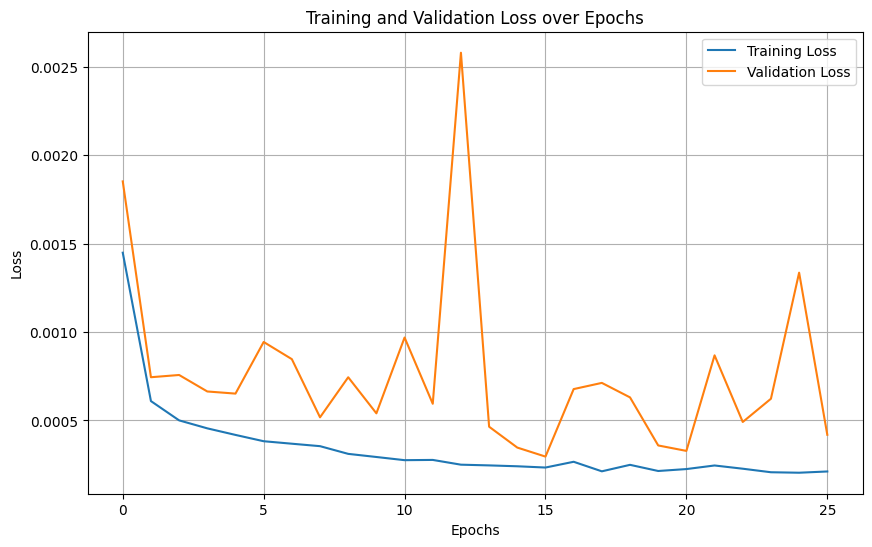

In [74]:
# Plotting training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

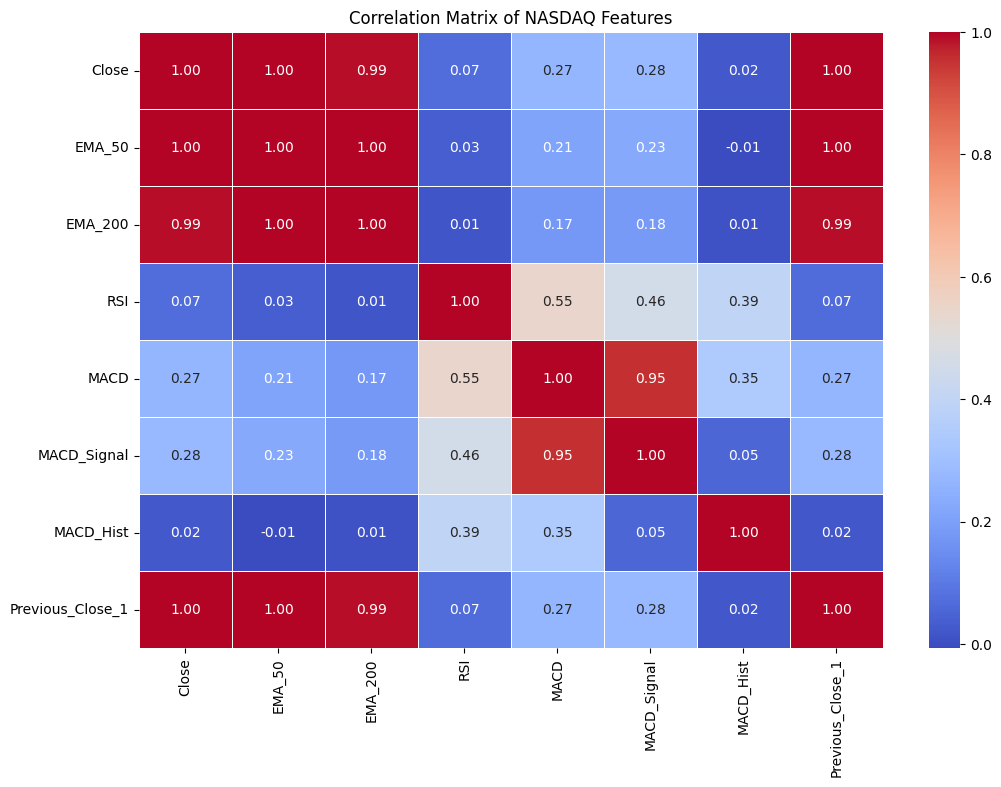

In [ ]:
import seaborn as sns
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Correlation Matrix of NASDAQ Features')
plt.show()

In [ ]:
X_train.shape[1], X_train.shape[2]

(60, 6)

In [75]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Make predictions
Y_pred_scaled = model.predict(X_test)

# Inverse transform the predictions and actual values
Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)
Y_actual = scaler_Y.inverse_transform(Y_test)

# Calculate MSE and RMSE
mse = mean_squared_error(Y_actual, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_actual, Y_pred)
r2 = r2_score(Y_actual,Y_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2 Score: {r2}')


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
MSE: 86159.8832928752
RMSE: 293.53003814409726
MAE: 222.0843103137035
R2 Score: 0.9754895084632232


In [76]:
# Define a threshold for a prediction to be considered 'true'
threshold = 0.02  # for example, 2%

# Calculate the absolute percent error for each prediction
errors = np.abs((Y_pred - Y_actual) / Y_actual)

# Count the number of 'true' predictions
num_true_predictions = np.sum(errors < threshold)

# Calculate the accuracy
accuracy = num_true_predictions / len(Y_pred)

print(f'Accuracy: {accuracy}')


Accuracy: 0.6893453145057766


In [77]:
# Generate predictions for the next 30 days
future_predictions = []
last_sequence = X_scaled[-lookback:]

for _ in range(30):
    # Make prediction
    next_prediction_scaled = model.predict(last_sequence.reshape(1, lookback, -1))
    next_prediction = scaler_Y.inverse_transform(next_prediction_scaled)
    future_predictions.append(next_prediction[0][0])

    # Update the sequence by appending the prediction and removing the oldest entry
    next_prediction_features = np.append(last_sequence[-1, :-1], next_prediction_scaled).reshape(1, -1)
    last_sequence = np.append(last_sequence[1:], next_prediction_features, axis=0)

# Prepare dates for plotting future predictions
last_date = pd.to_datetime(nasdaq_data['Date'].iloc[-1])
future_dates = [last_date + pd.DateOffset(days=i) for i in range(1, 31)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

In [78]:
# Print next 30 days prices with dates
for date, price in zip(future_dates, future_predictions):
    print(f'Date: {date}, Predicted Close Price: {price}')

Date: 2024-07-13 04:00:00+00:00, Predicted Close Price: 18382.505859375
Date: 2024-07-14 04:00:00+00:00, Predicted Close Price: 18389.2890625
Date: 2024-07-15 04:00:00+00:00, Predicted Close Price: 18400.333984375
Date: 2024-07-16 04:00:00+00:00, Predicted Close Price: 18414.32421875
Date: 2024-07-17 04:00:00+00:00, Predicted Close Price: 18429.18359375
Date: 2024-07-18 04:00:00+00:00, Predicted Close Price: 18443.30078125
Date: 2024-07-19 04:00:00+00:00, Predicted Close Price: 18455.748046875
Date: 2024-07-20 04:00:00+00:00, Predicted Close Price: 18466.162109375
Date: 2024-07-21 04:00:00+00:00, Predicted Close Price: 18474.5625
Date: 2024-07-22 04:00:00+00:00, Predicted Close Price: 18481.16796875
Date: 2024-07-23 04:00:00+00:00, Predicted Close Price: 18486.26171875
Date: 2024-07-24 04:00:00+00:00, Predicted Close Price: 18490.14453125
Date: 2024-07-25 04:00:00+00:00, Predicted Close Price: 18493.08203125
Date: 2024-07-26 04:00:00+00:00, Predicted Close Price: 18495.287109375
Date: 

In [48]:
Y_actual.shape, Y_pred.shape

((779, 1), (779, 1))

### Visualizations

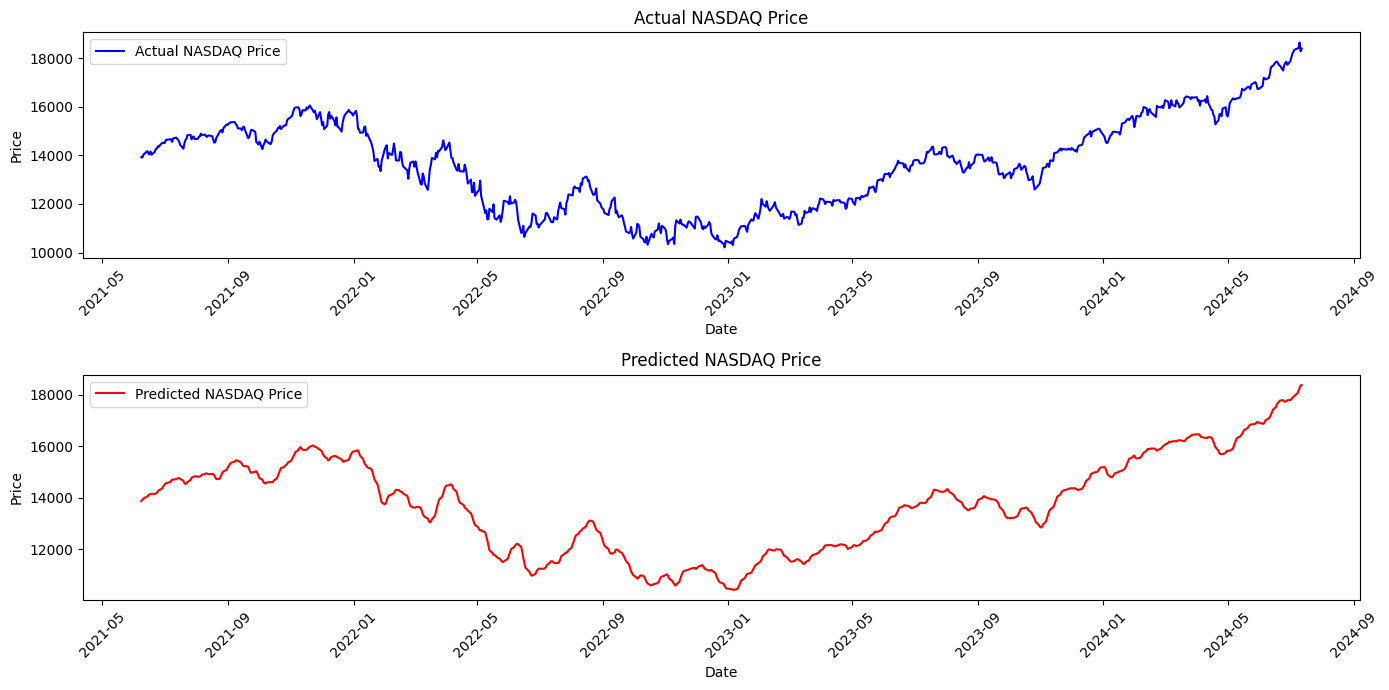

In [79]:
full_dates = pd.to_datetime(nasdaq_data['Date'])

# Plot actual and predicted values
plt.figure(figsize=(14, 7))

# Subplot 1: Actual values
plt.subplot(2, 1, 1)
plt.plot(full_dates[-len(Y_actual):], Y_actual, color='blue', label='Actual NASDAQ Price')
plt.title('Actual NASDAQ Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)

# Subplot 2: Predicted values
plt.subplot(2, 1, 2)
plt.plot(full_dates[-len(Y_pred):], Y_pred, color='red', label='Predicted NASDAQ Price')
plt.title('Predicted NASDAQ Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

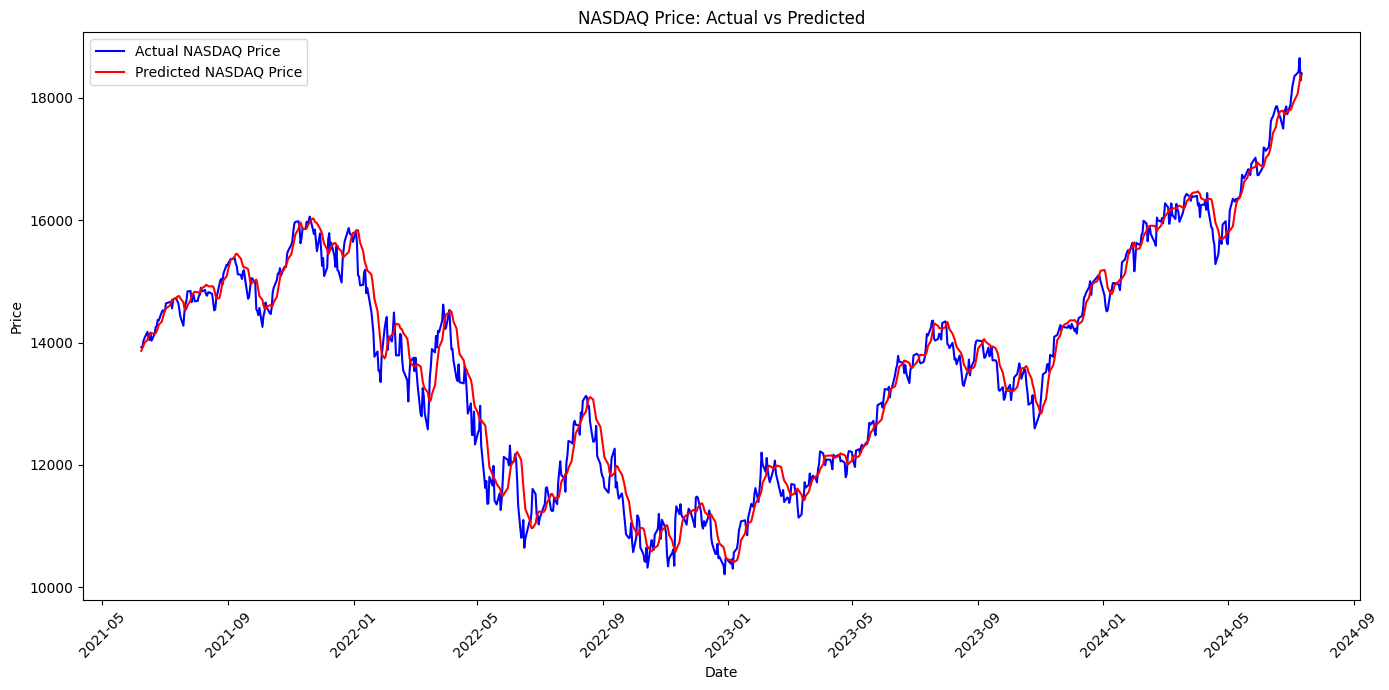

In [80]:
import matplotlib.pyplot as plt

# Create a figure
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(full_dates[-len(Y_actual):], Y_actual, color='blue', label='Actual NASDAQ Price')

# Plot predicted values
plt.plot(full_dates[-len(Y_pred):], Y_pred, color='red', label='Predicted NASDAQ Price')

# Set title, labels and legend
plt.title('NASDAQ Price: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


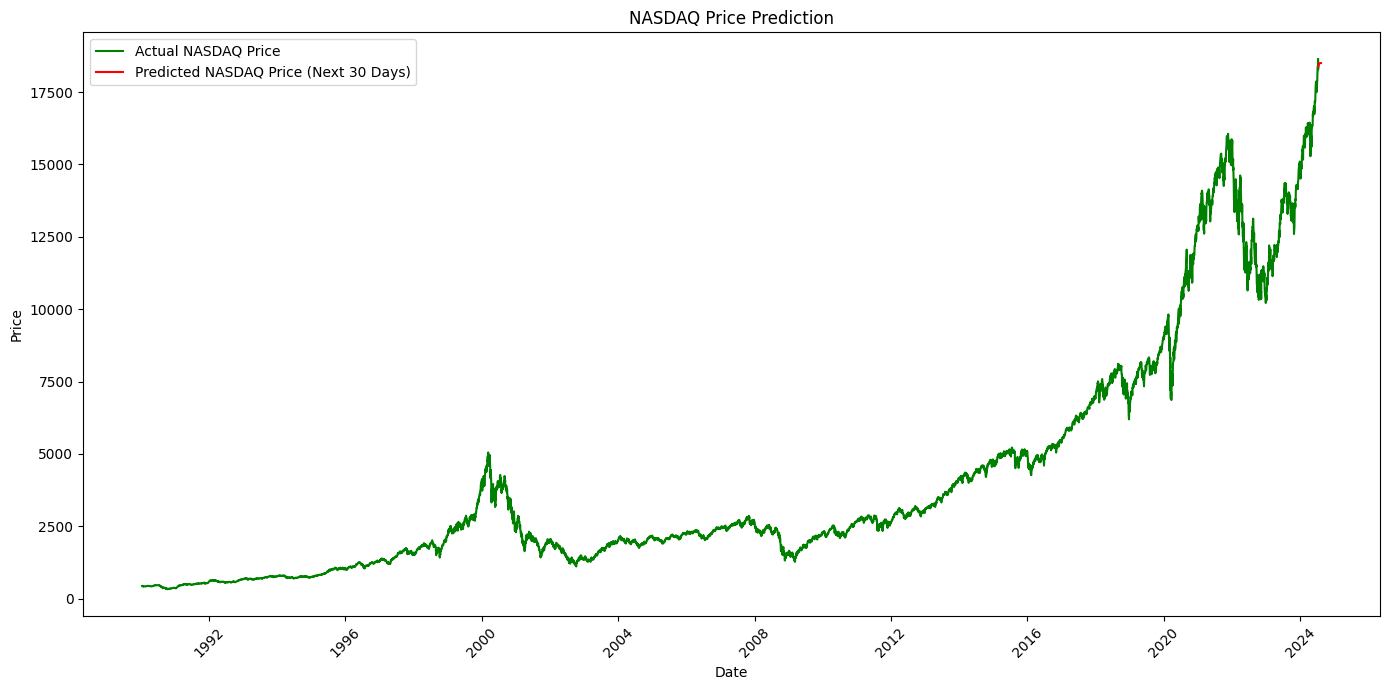

In [81]:
# Plot actual and predicted values
plt.figure(figsize=(14, 7))
plt.plot(full_dates[-len(Y_scaled):], scaler_Y.inverse_transform(Y_scaled).flatten(), color='green', label='Actual NASDAQ Price')
plt.plot(future_dates, future_predictions, color='red', label='Predicted NASDAQ Price (Next 30 Days)')
plt.title('NASDAQ Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


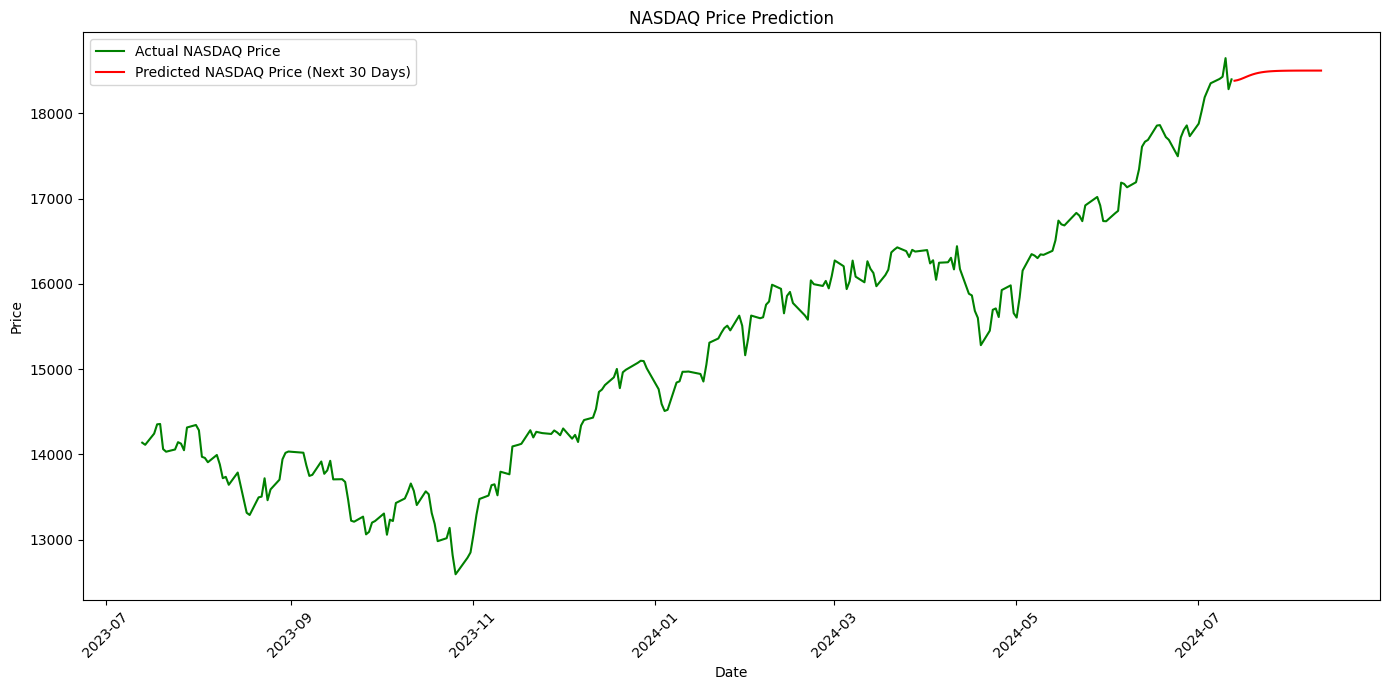

In [82]:
# Calculate the number of trading days in a year (usually around 252)
trading_days_in_a_year = 252

# Select the data for the last one year
last_year_dates = full_dates[-trading_days_in_a_year:]
last_year_prices = scaler_Y.inverse_transform(Y_scaled[-trading_days_in_a_year:]).flatten()

# Plot actual and predicted values
plt.figure(figsize=(14, 7))
plt.plot(last_year_dates, last_year_prices, color='green', label='Actual NASDAQ Price')
plt.plot(future_dates, future_predictions, color='red', label='Predicted NASDAQ Price (Next 30 Days)')
plt.title('NASDAQ Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Model Interpretability using LIME

In [41]:
import lime
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# LIME for model interpretability
explainer = LimeTabularExplainer(
    training_data=X_train.reshape(X_train.shape[0], -1),
    feature_names=features * lookback,
    class_names=['Close'],
    mode='regression'
)

# Choose an instance to explain (e.g., the first instance in the test set)
instance_idx = 0
instance = X_test[instance_idx].reshape(1, X_test.shape[1], X_test.shape[2])

# Get the predicted value for the instance
predicted_value_scaled = model.predict(instance).flatten()[0]

# Inverse transform the predicted value to get it back to the original scale
predicted_value_original_scale = scaler_Y.inverse_transform([[predicted_value_scaled]])[0][0]

# Get the actual value for the instance
actual_value_scaled = Y_test[instance_idx].reshape(1, -1)  # Reshape to 2D array
actual_value_original_scale = scaler_Y.inverse_transform(actual_value_scaled)[0][0]

# Print the predicted and actual values
print(f'Original value for the instance: {actual_value_original_scale}')
print(f'Predicted value for the instance: {predicted_value_original_scale}')

print(f'Predicted value for the instance (scaled): {predicted_value_scaled}')


# Explain the instance
exp = explainer.explain_instance(
    data_row=instance.flatten(),
    predict_fn=lambda x: model.predict(x.reshape(-1, X_test.shape[1], X_test.shape[2])).flatten(),
    num_features=len(features)  # Include all features in the explanation
)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Original value for the instance: 13924.91015625
Predicted value for the instance: 13874.467775974428
Predicted value for the instance (scaled): 0.7394952178001404
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step


In [42]:
# Explain the instance
exp = explainer.explain_instance(
    data_row=instance.flatten(),
    predict_fn=lambda x: model.predict(x.reshape(-1, X_test.shape[1], X_test.shape[2])).flatten(),
    num_features=len(features)  # Include all features in the explanation
)

157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step


In [43]:
# Show the explanation
exp.show_in_notebook(show_table=True)
